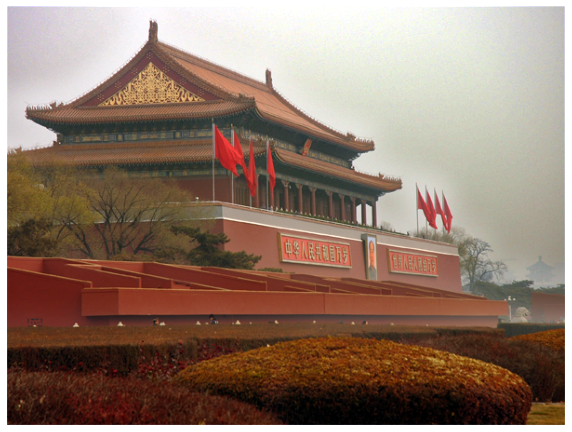

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

def get_dark_channel(img, wind_size):
    dark_channel = np.zeros((img.shape[0], img.shape[1]))
    img = cv2.copyMakeBorder(img,wind_size//2,wind_size//2,wind_size//2,wind_size//2,cv2.BORDER_CONSTANT,value=[255,255,255])    
    no_rows = img.shape[0]
    no_cols = img.shape[1]
    min_channel = np.zeros((no_rows, no_cols))
    for row in range(no_rows):
        for col in range(no_cols):
            min_channel[row-wind_size//2][col-wind_size//2] = np.min(img[row,col,:])
    for row in range(wind_size//2, no_rows-wind_size//2):
        for col in range(wind_size//2, no_cols-wind_size//2):
            dark_channel[row-wind_size//2][col-wind_size//2] = np.min(min_channel[row-wind_size//2:row+wind_size//2,col-wind_size//2:col+wind_size//2])
    return dark_channel

def get_atm_light(im, dark_channel_img):
    img = im.copy()
    num_pixels = dark_channel_img.size
    num_brightest = num_pixels//1000
    haze_density_sort_idx = np.argsort(dark_channel_img,axis=None)[::-1]
    brightest = haze_density_sort_idx[0:num_brightest]
    brightest = np.unravel_index(brightest,dark_channel_img.shape)
    brightest_pixels = img[brightest]
    top_intensities = np.average(brightest_pixels, axis=1)
    max_intensity = np.argmax(top_intensities)
    A = brightest_pixels[max_intensity]
    img[brightest]=[255,0,0]
    row_min = np.min(brightest[0])
    row_max = np.max(brightest[0])
    col_min = np.min(brightest[1])
    col_max = np.max(brightest[1])
    cv2.rectangle(img, (col_min,row_min),(col_max,row_max),(0,0,255),thickness=2)
    return A

def refine(img, transmission, radius, epsilon):
    mean_guide = cv2.blur(img,(radius,radius))
    mean_trans = cv2.blur(transmission,(radius,radius))
    mean_gt = cv2.blur(img * transmission, (radius,radius))
    
    a = mean_gt - mean_guide * mean_trans
    var_guide = cv2.blur(img * img,(radius,radius)) - (mean_guide * mean_guide)
    a = a/(var_guide + epsilon)
    b = mean_trans - a * mean_guide


    q = cv2.blur(a,(radius,radius)) * img + cv2.blur(b,(radius,radius))
    return q

def recover_image(img, trans_bar, atm_light, t0):
    trans_recover = np.copy(trans_bar)
    trans_recover[trans_recover < t0] = t0
    J = np.zeros((img.shape))
    J[:,:,0] = ((img[:,:,0] - atm_light[0])/trans_recover) + atm_light[0]
    J[:,:,1] = ((img[:,:,1] - atm_light[1])/trans_recover) + atm_light[1]
    J[:,:,2] = ((img[:,:,2] - atm_light[2])/trans_recover) + atm_light[2]
    return J

def color_balance(img, s):
    out = np.copy(img)
    hist = np.zeros((256,1))
    no_of_pixels = img.shape[0] * img.shape[1]
    for i in range(3):
        channel_vals = img[:,:,i]
        for pixel_val in range(256):
            hist[pixel_val] = np.sum((channel_vals == pixel_val)) 
        for pixel_val in range(256):
            hist[pixel_val] = hist[pixel_val-1] + hist[pixel_val]
        Vmin = 0
        while (Vmin < 255 and hist[Vmin] <= no_of_pixels*s):
            Vmin += 1
        Vmax = 255
        while (Vmax > 0 and hist[Vmax] > no_of_pixels*(1-s)):
            Vmax -= 1
        channel_vals[channel_vals < Vmin] = Vmin
        channel_vals[channel_vals > Vmax] = Vmax
        out[:,:,i] = cv2.normalize(channel_vals, channel_vals.copy(), 0, 255, cv2.NORM_MINMAX)
    return out

def run(img, omega, t0, radius, dark_rad):
    dark_channel_img = get_dark_channel(img, dark_rad)
    dark_channel_img = dark_channel_img.astype('uint8')
    atm_light = get_atm_light(img,dark_channel_img)
    t_bar = get_dark_channel(img/atm_light,dark_rad)
    trans_bar = 1-(omega * t_bar)
    i=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)/255
    t_refine = refine(i, trans_bar, radius, 0.0001)
    im = img.astype("double")
    J = recover_image(im, t_refine, atm_light, t0)
    J = ((J-np.min(J))/(np.max(J)-np.min(J)))*255
    cb_J = color_balance(np.uint8(J),0.005)
    return cb_J

img = cv2.imread('./Dataset/Other/1.png')
#img = cv2.resize(img, (0,0), fx=0.25, fy=0.25)
result = run(img,0.85,0.1,30,15)
plt.figure(figsize=(10,10))
plt.imshow(result[...,::-1])
plt.axis('off')
plt.show()
